# Mask R-CNN - Train on Simple Baby Dataset

Modification of the Shapes Training sample.

# Mask R-CNN - Train on Shapes Dataset


This notebook shows how to train Mask R-CNN on your own dataset. To keep things simple we use a synthetic dataset of shapes (squares, triangles, and circles) which enables fast training. You'd still need a GPU, though, because the network backbone is a Resnet101, which would be too slow to train on a CPU. On a GPU, you can start to get okay-ish results in a few minutes, and good results in less than an hour.

The code of the *Shapes* dataset is included below. It generates images on the fly, so it doesn't require downloading any data. And it can generate images of any size, so we pick a small image size to train faster. 

In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt
import skimage

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

## Configurations

In [2]:
class BabiesConfig(Config):
    """Configuration for training on the babies dataset.
    Derives from the base Config class and overrides values specific
    to the babies dataset.
    """
    # Give the configuration a recognizable name
    NAME = "babies"
    
    # Backbone network architecture
    # Supported values are: resnet50, resnet101.
    # You can also provide a callable that should have the signature
    # of model.resnet_graph. If you do so, you need to supply a callable
    # to COMPUTE_BACKBONE_SHAPE as well
    BACKBONE = "resnet101"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 3

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + 1 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 128
    IMAGE_MAX_DIM = 128
    
    USE_MINI_MASK = False

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 28

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
config = BabiesConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     3
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 3
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  128
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  128
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [128 128   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

## Notebook Preferences

In [3]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset

Create a synthetic dataset

Extend the Dataset class and add a method to load the shapes dataset, `load_shapes()`, and override the following methods:

* load_image()
* load_mask()
* image_reference()

In [4]:
class BabiesDataset(utils.Dataset):
    """Generates the babies dataset.
    """

    def load_babies(self, count, validation=False):
        """Generate the requested number of images.
        count: number of images to generate.
        validation: whether this is validation set.
        """
        # Add classes
        self.add_class("babies", 1, "baby")
        
        image_dir = 'Images'
        if validation:
            image_dir = os.path.join(image_dir, 'Validation')
        else:
            image_dir = os.path.join(image_dir, 'Training')

        # Add images
        for i in range(count):
            image_path = os.path.join(image_dir, '{}.png'.format(i))
            image = skimage.io.imread(image_path)
            if image.shape[2] == 4:
                image = image[:,:,:3]
            
            self.add_image("babies", image_id=i, path=image_path,
                           height=image.shape[0], width=image.shape[1])

    def image_reference(self, image_id):
        """Return the shapes data of the image."""
        info = self.image_info[image_id]
        if info["source"] == "shapes":
            return info["shapes"]
        elif info["source"] == "babies":
            return info
        else:
            super(self.__class__).image_reference(self, image_id)

    def load_mask(self, image_id):
        """Generate instance masks for shapes of the given image ID.
        """
        info = self.image_info[image_id]
        image_path = info['path']
        validation_path = image_path.replace('.png', '.labels.tif')
        mask = skimage.io.imread(validation_path)
        mask = mask.reshape((mask.shape[0], mask.shape[1], 1))
        class_ids = np.array([1], np.int32)
        return mask.astype(np.bool), class_ids.astype(np.int32)

In [5]:
# Training dataset
dataset_train = BabiesDataset()
dataset_train.load_babies(28)
dataset_train.prepare()

# Validation dataset
dataset_val = BabiesDataset()
dataset_val.load_babies(5, validation=True)
dataset_val.prepare()

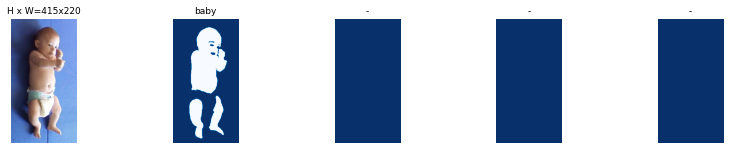

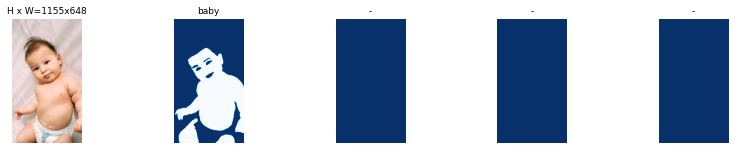

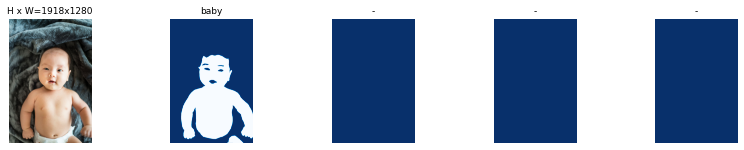

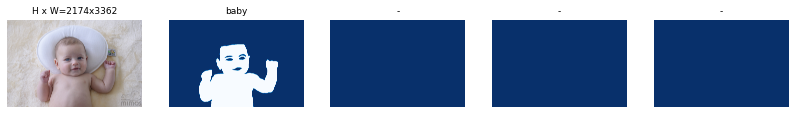

In [6]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

## Create Model

In [7]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [8]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [9]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=20, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /home/svu/e0201435/Mask_RCNN/logs/babies20210211T1208/mask_rcnn_babies_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrc

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


28/28 [==============================] - 51s 2s/step - loss: 1.8343 - rpn_class_loss: 0.0984 - rpn_bbox_loss: 0.6125 - mrcnn_class_loss: 0.1111 - mrcnn_bbox_loss: 0.5599 - mrcnn_mask_loss: 0.4523 - val_loss: 1.1324 - val_rpn_class_loss: 0.0195 - val_rpn_bbox_loss: 0.4436 - val_mrcnn_class_loss: 0.0178 - val_mrcnn_bbox_loss: 0.3134 - val_mrcnn_mask_loss: 0.3382
Epoch 2/20
28/28 [==============================] - 14s 494ms/step - loss: 0.7737 - rpn_class_loss: 0.0103 - rpn_bbox_loss: 0.2169 - mrcnn_class_loss: 0.0227 - mrcnn_bbox_loss: 0.2385 - mrcnn_mask_loss: 0.2854 - val_loss: 1.1768 - val_rpn_class_loss: 0.0090 - val_rpn_bbox_loss: 0.3754 - val_mrcnn_class_loss: 0.0390 - val_mrcnn_bbox_loss: 0.4287 - val_mrcnn_mask_loss: 0.3246
Epoch 3/20
26/28 [==========================>...] - ETA: 0s - loss: 0.6797 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.1804 - mrcnn_class_loss: 0.0642 - mrcnn_bbox_loss: 0.1548 - mrcnn_mask_loss: 0.2736WARNING:tensorflow:Method (on_train_batch_end) is slow com

28/28 [==============================] - 12s 435ms/step - loss: 0.6725 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.1812 - mrcnn_class_loss: 0.0626 - mrcnn_bbox_loss: 0.1536 - mrcnn_mask_loss: 0.2686 - val_loss: 1.1042 - val_rpn_class_loss: 0.0074 - val_rpn_bbox_loss: 0.6189 - val_mrcnn_class_loss: 0.0424 - val_mrcnn_bbox_loss: 0.1606 - val_mrcnn_mask_loss: 0.2749
Epoch 4/20
28/28 [==============================] - 13s 450ms/step - loss: 0.5517 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.1689 - mrcnn_class_loss: 0.0303 - mrcnn_bbox_loss: 0.1146 - mrcnn_mask_loss: 0.2324 - val_loss: 0.8687 - val_rpn_class_loss: 0.0063 - val_rpn_bbox_loss: 0.4151 - val_mrcnn_class_loss: 0.0124 - val_mrcnn_bbox_loss: 0.1343 - val_mrcnn_mask_loss: 0.3006


Epoch 5/20
28/28 [==============================] - 14s 488ms/step - loss: 0.4013 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.1080 - mrcnn_class_loss: 0.0105 - mrcnn_bbox_loss: 0.0758 - mrcnn_mask_loss: 0.2014 - val_loss: 0.9067 - val_rpn_class_loss: 0.0073 - val_rpn_bbox_loss: 0.3975 - val_mrcnn_class_loss: 0.0095 - val_mrcnn_bbox_loss: 0.1837 - val_mrcnn_mask_loss: 0.3087
Epoch 6/20
28/28 [==============================] - 12s 426ms/step - loss: 0.3960 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.1124 - mrcnn_class_loss: 0.0372 - mrcnn_bbox_loss: 0.0650 - mrcnn_mask_loss: 0.1764 - val_loss: 1.0545 - val_rpn_class_loss: 0.0064 - val_rpn_bbox_loss: 0.5500 - val_mrcnn_class_loss: 0.0873 - val_mrcnn_bbox_loss: 0.1515 - val_mrcnn_mask_loss: 0.2593
Epoch 7/20
27/28 [===========================>..] - ETA: 0s - loss: 0.3410 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.0765 - mrcnn_class_loss: 0.0390 - mrcnn_bbox_loss: 0.0477 - mrcnn_mask_loss: 0.1732WARNING:tensorflow:Method (on_train_batch_en

28/28 [==============================] - 13s 481ms/step - loss: 0.3429 - rpn_class_loss: 0.0045 - rpn_bbox_loss: 0.0782 - mrcnn_class_loss: 0.0391 - mrcnn_bbox_loss: 0.0482 - mrcnn_mask_loss: 0.1729 - val_loss: 0.7593 - val_rpn_class_loss: 0.0056 - val_rpn_bbox_loss: 0.2931 - val_mrcnn_class_loss: 0.0568 - val_mrcnn_bbox_loss: 0.1545 - val_mrcnn_mask_loss: 0.2493
Epoch 8/20
28/28 [==============================] - 13s 479ms/step - loss: 0.3256 - rpn_class_loss: 0.0043 - rpn_bbox_loss: 0.0690 - mrcnn_class_loss: 0.0475 - mrcnn_bbox_loss: 0.0398 - mrcnn_mask_loss: 0.1650 - val_loss: 0.9557 - val_rpn_class_loss: 0.0059 - val_rpn_bbox_loss: 0.4564 - val_mrcnn_class_loss: 0.0417 - val_mrcnn_bbox_loss: 0.1982 - val_mrcnn_mask_loss: 0.2535
Epoch 9/20
28/28 [==============================] - 12s 439ms/step - loss: 0.2721 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.0465 - mrcnn_class_loss: 0.0425 - mrcnn_bbox_loss: 0.0283 - mrcnn_mask_loss: 0.1510 - val_loss: 1.0155 - val_rpn_class_loss: 0.0044

28/28 [==============================] - 12s 438ms/step - loss: 0.2676 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0464 - mrcnn_class_loss: 0.0483 - mrcnn_bbox_loss: 0.0277 - mrcnn_mask_loss: 0.1419 - val_loss: 0.7329 - val_rpn_class_loss: 0.0057 - val_rpn_bbox_loss: 0.3159 - val_mrcnn_class_loss: 0.0371 - val_mrcnn_bbox_loss: 0.1272 - val_mrcnn_mask_loss: 0.2469
Epoch 11/20
28/28 [==============================] - 12s 438ms/step - loss: 0.2404 - rpn_class_loss: 0.0036 - rpn_bbox_loss: 0.0297 - mrcnn_class_loss: 0.0367 - mrcnn_bbox_loss: 0.0274 - mrcnn_mask_loss: 0.1429 - val_loss: 0.9229 - val_rpn_class_loss: 0.0051 - val_rpn_bbox_loss: 0.4672 - val_mrcnn_class_loss: 0.0485 - val_mrcnn_bbox_loss: 0.1660 - val_mrcnn_mask_loss: 0.2361
Epoch 12/20
14/28 [==============>...............] - ETA: 4s - loss: 0.2306 - rpn_class_loss: 0.0034 - rpn_bbox_loss: 0.0215 - mrcnn_class_loss: 0.0425 - mrcnn_bbox_loss: 0.0234 - mrcnn_mask_loss: 0.1398WARNING:tensorflow:Method (on_train_batch_end) is slo

28/28 [==============================] - 12s 433ms/step - loss: 0.2262 - rpn_class_loss: 0.0035 - rpn_bbox_loss: 0.0212 - mrcnn_class_loss: 0.0395 - mrcnn_bbox_loss: 0.0245 - mrcnn_mask_loss: 0.1375 - val_loss: 0.9802 - val_rpn_class_loss: 0.0045 - val_rpn_bbox_loss: 0.4646 - val_mrcnn_class_loss: 0.0328 - val_mrcnn_bbox_loss: 0.1928 - val_mrcnn_mask_loss: 0.2853
Epoch 13/20
28/28 [==============================] - 13s 449ms/step - loss: 0.1958 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0150 - mrcnn_class_loss: 0.0350 - mrcnn_bbox_loss: 0.0158 - mrcnn_mask_loss: 0.1269 - val_loss: 0.8675 - val_rpn_class_loss: 0.0056 - val_rpn_bbox_loss: 0.3529 - val_mrcnn_class_loss: 0.0564 - val_mrcnn_bbox_loss: 0.1705 - val_mrcnn_mask_loss: 0.2822
Epoch 14/20
19/28 [===================>..........] - ETA: 2s - loss: 0.1734 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0114 - mrcnn_class_loss: 0.0207 - mrcnn_bbox_loss: 0.0095 - mrcnn_mask_loss: 0.1287WARNING:tensorflow:Method (on_train_batch_end) is slo

28/28 [==============================] - 13s 470ms/step - loss: 0.1693 - rpn_class_loss: 0.0030 - rpn_bbox_loss: 0.0096 - mrcnn_class_loss: 0.0208 - mrcnn_bbox_loss: 0.0096 - mrcnn_mask_loss: 0.1264 - val_loss: 0.8127 - val_rpn_class_loss: 0.0044 - val_rpn_bbox_loss: 0.3404 - val_mrcnn_class_loss: 0.0471 - val_mrcnn_bbox_loss: 0.1567 - val_mrcnn_mask_loss: 0.2640
Epoch 15/20
28/28 [==============================] - 12s 420ms/step - loss: 0.1588 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.0058 - mrcnn_class_loss: 0.0232 - mrcnn_bbox_loss: 0.0073 - mrcnn_mask_loss: 0.1200 - val_loss: 0.7168 - val_rpn_class_loss: 0.0052 - val_rpn_bbox_loss: 0.2731 - val_mrcnn_class_loss: 0.0451 - val_mrcnn_bbox_loss: 0.1233 - val_mrcnn_mask_loss: 0.2702
Epoch 16/20
23/28 [=======================>......] - ETA: 1s - loss: 0.1494 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.0064 - mrcnn_class_loss: 0.0183 - mrcnn_bbox_loss: 0.0072 - mrcnn_mask_loss: 0.1147WARNING:tensorflow:Method (on_train_batch_end) is slo

28/28 [==============================] - 12s 444ms/step - loss: 0.1487 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.0064 - mrcnn_class_loss: 0.0185 - mrcnn_bbox_loss: 0.0073 - mrcnn_mask_loss: 0.1139 - val_loss: 0.7179 - val_rpn_class_loss: 0.0034 - val_rpn_bbox_loss: 0.2737 - val_mrcnn_class_loss: 0.0408 - val_mrcnn_bbox_loss: 0.1200 - val_mrcnn_mask_loss: 0.2800
Epoch 17/20
28/28 [==============================] - 13s 459ms/step - loss: 0.1542 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.0039 - mrcnn_class_loss: 0.0249 - mrcnn_bbox_loss: 0.0080 - mrcnn_mask_loss: 0.1146 - val_loss: 0.9166 - val_rpn_class_loss: 0.0047 - val_rpn_bbox_loss: 0.4184 - val_mrcnn_class_loss: 0.0697 - val_mrcnn_bbox_loss: 0.1590 - val_mrcnn_mask_loss: 0.2647
Epoch 18/20
28/28 [==============================] - 14s 494ms/step - loss: 0.1525 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.0049 - mrcnn_class_loss: 0.0151 - mrcnn_bbox_loss: 0.0167 - mrcnn_mask_loss: 0.1134 - val_loss: 0.8563 - val_rpn_class_loss: 0.00

28/28 [==============================] - 13s 453ms/step - loss: 0.1504 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0035 - mrcnn_class_loss: 0.0255 - mrcnn_bbox_loss: 0.0109 - mrcnn_mask_loss: 0.1080 - val_loss: 0.9369 - val_rpn_class_loss: 0.0039 - val_rpn_bbox_loss: 0.3997 - val_mrcnn_class_loss: 0.0418 - val_mrcnn_bbox_loss: 0.2077 - val_mrcnn_mask_loss: 0.2838
Epoch 20/20
28/28 [==============================] - 13s 472ms/step - loss: 0.1470 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0037 - mrcnn_class_loss: 0.0227 - mrcnn_bbox_loss: 0.0084 - mrcnn_mask_loss: 0.1099 - val_loss: 0.6626 - val_rpn_class_loss: 0.0035 - val_rpn_bbox_loss: 0.2356 - val_mrcnn_class_loss: 0.0728 - val_mrcnn_bbox_loss: 0.1025 - val_mrcnn_mask_loss: 0.2482


In [10]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=40, 
            layers="all")


Starting at epoch 20. LR=0.0001

Checkpoint Path: /home/svu/e0201435/Mask_RCNN/logs/babies20210211T1208/mask_rcnn_babies_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)
b

Epoch 21/40


/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


28/28 [==============================] - 31s 1s/step - loss: 0.3059 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0142 - mrcnn_class_loss: 0.0205 - mrcnn_bbox_loss: 0.0091 - mrcnn_mask_loss: 0.1069 - val_loss: 1.4421 - val_rpn_class_loss: 0.0037 - val_rpn_bbox_loss: 0.3032 - val_mrcnn_class_loss: 0.0336 - val_mrcnn_bbox_loss: 0.1150 - val_mrcnn_mask_loss: 0.2656
Epoch 22/40
28/28 [==============================] - 26s 943ms/step - loss: 0.3316 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.0216 - mrcnn_class_loss: 0.0187 - mrcnn_bbox_loss: 0.0113 - mrcnn_mask_loss: 0.1117 - val_loss: 1.7971 - val_rpn_class_loss: 0.0035 - val_rpn_bbox_loss: 0.3999 - val_mrcnn_class_loss: 0.0665 - val_mrcnn_bbox_loss: 0.1572 - val_mrcnn_mask_loss: 0.2715
Epoch 23/40
 8/28 [=======>......................] - ETA: 14s - loss: 0.3194 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.0173 - mrcnn_class_loss: 0.0198 - mrcnn_bbox_loss: 0.0093 - mrcnn_mask_loss: 0.1109WARNING:tensorflow:Method (on_train_batch_end) is slow 

28/28 [==============================] - 28s 983ms/step - loss: 0.2940 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.0119 - mrcnn_class_loss: 0.0163 - mrcnn_bbox_loss: 0.0084 - mrcnn_mask_loss: 0.1078 - val_loss: 2.0667 - val_rpn_class_loss: 0.0044 - val_rpn_bbox_loss: 0.4657 - val_mrcnn_class_loss: 0.1128 - val_mrcnn_bbox_loss: 0.1780 - val_mrcnn_mask_loss: 0.2725
Epoch 24/40
28/28 [==============================] - 29s 1s/step - loss: 0.3193 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.0118 - mrcnn_class_loss: 0.0232 - mrcnn_bbox_loss: 0.0161 - mrcnn_mask_loss: 0.1059 - val_loss: 1.2250 - val_rpn_class_loss: 0.0042 - val_rpn_bbox_loss: 0.2212 - val_mrcnn_class_loss: 0.0179 - val_mrcnn_bbox_loss: 0.1034 - val_mrcnn_mask_loss: 0.2659
Epoch 25/40
13/28 [============>.................] - ETA: 14s - loss: 0.2603 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0080 - mrcnn_class_loss: 0.0092 - mrcnn_bbox_loss: 0.0105 - mrcnn_mask_loss: 0.1002WARNING:tensorflow:Method (on_train_batch_end) is slow 

28/28 [==============================] - 34s 1s/step - loss: 0.2615 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0056 - mrcnn_class_loss: 0.0140 - mrcnn_bbox_loss: 0.0075 - mrcnn_mask_loss: 0.1013 - val_loss: 1.8192 - val_rpn_class_loss: 0.0047 - val_rpn_bbox_loss: 0.4189 - val_mrcnn_class_loss: 0.0664 - val_mrcnn_bbox_loss: 0.1362 - val_mrcnn_mask_loss: 0.2832
Epoch 26/40
28/28 [==============================] - 31s 1s/step - loss: 0.2540 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0048 - mrcnn_class_loss: 0.0140 - mrcnn_bbox_loss: 0.0050 - mrcnn_mask_loss: 0.1008 - val_loss: 1.7838 - val_rpn_class_loss: 0.0038 - val_rpn_bbox_loss: 0.4245 - val_mrcnn_class_loss: 0.0657 - val_mrcnn_bbox_loss: 0.1291 - val_mrcnn_mask_loss: 0.2688
Epoch 27/40
17/28 [=================>............] - ETA: 10s - loss: 0.2450 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.0030 - mrcnn_class_loss: 0.0122 - mrcnn_bbox_loss: 0.0034 - mrcnn_mask_loss: 0.1014WARNING:tensorflow:Method (on_train_batch_end) is slow com

28/28 [==============================] - 32s 1s/step - loss: 0.2432 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0025 - mrcnn_class_loss: 0.0108 - mrcnn_bbox_loss: 0.0035 - mrcnn_mask_loss: 0.1024 - val_loss: 1.5467 - val_rpn_class_loss: 0.0035 - val_rpn_bbox_loss: 0.3477 - val_mrcnn_class_loss: 0.0510 - val_mrcnn_bbox_loss: 0.1045 - val_mrcnn_mask_loss: 0.2667
Epoch 28/40
28/28 [==============================] - 30s 1s/step - loss: 0.2223 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 0.0016 - mrcnn_class_loss: 0.0074 - mrcnn_bbox_loss: 0.0030 - mrcnn_mask_loss: 0.0969 - val_loss: 1.8893 - val_rpn_class_loss: 0.0033 - val_rpn_bbox_loss: 0.4322 - val_mrcnn_class_loss: 0.0885 - val_mrcnn_bbox_loss: 0.1452 - val_mrcnn_mask_loss: 0.2754
Epoch 29/40
21/28 [=====================>........] - ETA: 6s - loss: 0.2085 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 8.7599e-04 - mrcnn_class_loss: 0.0057 - mrcnn_bbox_loss: 0.0021 - mrcnn_mask_loss: 0.0932WARNING:tensorflow:Method (on_train_batch_end) is slow 

28/28 [==============================] - 35s 1s/step - loss: 0.2186 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 9.3213e-04 - mrcnn_class_loss: 0.0078 - mrcnn_bbox_loss: 0.0028 - mrcnn_mask_loss: 0.0952 - val_loss: 1.6911 - val_rpn_class_loss: 0.0031 - val_rpn_bbox_loss: 0.3727 - val_mrcnn_class_loss: 0.0738 - val_mrcnn_bbox_loss: 0.1252 - val_mrcnn_mask_loss: 0.2707
Epoch 30/40
23/28 [=======================>......] - ETA: 3s - loss: 0.2152 - rpn_class_loss: 0.0019 - rpn_bbox_loss: 6.9524e-04 - mrcnn_class_loss: 0.0071 - mrcnn_bbox_loss: 0.0023 - mrcnn_mask_loss: 0.0956WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.542421). Check your callbacks.


28/28 [==============================] - 26s 938ms/step - loss: 0.2214 - rpn_class_loss: 0.0019 - rpn_bbox_loss: 7.1720e-04 - mrcnn_class_loss: 0.0077 - mrcnn_bbox_loss: 0.0022 - mrcnn_mask_loss: 0.0981 - val_loss: 1.6060 - val_rpn_class_loss: 0.0041 - val_rpn_bbox_loss: 0.3532 - val_mrcnn_class_loss: 0.0575 - val_mrcnn_bbox_loss: 0.1172 - val_mrcnn_mask_loss: 0.2711
Epoch 31/40
25/28 [=========================>....] - ETA: 2s - loss: 0.2084 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 6.8268e-04 - mrcnn_class_loss: 0.0054 - mrcnn_bbox_loss: 0.0013 - mrcnn_mask_loss: 0.0947WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.510677). Check your callbacks.


28/28 [==============================] - 26s 922ms/step - loss: 0.2098 - rpn_class_loss: 0.0020 - rpn_bbox_loss: 6.4299e-04 - mrcnn_class_loss: 0.0060 - mrcnn_bbox_loss: 0.0013 - mrcnn_mask_loss: 0.0949 - val_loss: 1.6966 - val_rpn_class_loss: 0.0039 - val_rpn_bbox_loss: 0.3369 - val_mrcnn_class_loss: 0.1080 - val_mrcnn_bbox_loss: 0.1195 - val_mrcnn_mask_loss: 0.2800
Epoch 32/40
27/28 [===========================>..] - ETA: 0s - loss: 0.2230 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 9.3380e-04 - mrcnn_class_loss: 0.0104 - mrcnn_bbox_loss: 0.0021 - mrcnn_mask_loss: 0.0958WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.549927). Check your callbacks.


28/28 [==============================] - 27s 964ms/step - loss: 0.2221 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 9.2683e-04 - mrcnn_class_loss: 0.0101 - mrcnn_bbox_loss: 0.0021 - mrcnn_mask_loss: 0.0957 - val_loss: 1.3261 - val_rpn_class_loss: 0.0031 - val_rpn_bbox_loss: 0.2583 - val_mrcnn_class_loss: 0.0270 - val_mrcnn_bbox_loss: 0.1066 - val_mrcnn_mask_loss: 0.2680
Epoch 33/40
28/28 [==============================] - 26s 946ms/step - loss: 0.2102 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 5.5497e-04 - mrcnn_class_loss: 0.0059 - mrcnn_bbox_loss: 0.0012 - mrcnn_mask_loss: 0.0952 - val_loss: 1.7479 - val_rpn_class_loss: 0.0033 - val_rpn_bbox_loss: 0.3971 - val_mrcnn_class_loss: 0.0698 - val_mrcnn_bbox_loss: 0.1295 - val_mrcnn_mask_loss: 0.2742


Epoch 34/40
28/28 [==============================] - 27s 979ms/step - loss: 0.2057 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 3.6223e-04 - mrcnn_class_loss: 0.0055 - mrcnn_bbox_loss: 0.0015 - mrcnn_mask_loss: 0.0934 - val_loss: 1.6426 - val_rpn_class_loss: 0.0038 - val_rpn_bbox_loss: 0.3487 - val_mrcnn_class_loss: 0.0480 - val_mrcnn_bbox_loss: 0.1388 - val_mrcnn_mask_loss: 0.2819
Epoch 35/40
 4/28 [===>..........................] - ETA: 16s - loss: 0.2118 - rpn_class_loss: 0.0023 - rpn_bbox_loss: 2.6169e-04 - mrcnn_class_loss: 0.0105 - mrcnn_bbox_loss: 0.0015 - mrcnn_mask_loss: 0.0914WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.538169). Check your callbacks.


28/28 [==============================] - 26s 927ms/step - loss: 0.2002 - rpn_class_loss: 0.0019 - rpn_bbox_loss: 3.7471e-04 - mrcnn_class_loss: 0.0050 - mrcnn_bbox_loss: 0.0011 - mrcnn_mask_loss: 0.0918 - val_loss: 1.3403 - val_rpn_class_loss: 0.0039 - val_rpn_bbox_loss: 0.2837 - val_mrcnn_class_loss: 0.0436 - val_mrcnn_bbox_loss: 0.0846 - val_mrcnn_mask_loss: 0.2544
Epoch 36/40
 6/28 [=====>........................] - ETA: 17s - loss: 0.1827 - rpn_class_loss: 0.0020 - rpn_bbox_loss: 4.6544e-04 - mrcnn_class_loss: 0.0049 - mrcnn_bbox_loss: 0.0010 - mrcnn_mask_loss: 0.0829  WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.541837). Check your callbacks.


28/28 [==============================] - 27s 951ms/step - loss: 0.1930 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 3.3226e-04 - mrcnn_class_loss: 0.0038 - mrcnn_bbox_loss: 8.5160e-04 - mrcnn_mask_loss: 0.0894 - val_loss: 1.4957 - val_rpn_class_loss: 0.0033 - val_rpn_bbox_loss: 0.3011 - val_mrcnn_class_loss: 0.0401 - val_mrcnn_bbox_loss: 0.1188 - val_mrcnn_mask_loss: 0.2846
Epoch 37/40
28/28 [==============================] - 27s 968ms/step - loss: 0.1984 - rpn_class_loss: 0.0019 - rpn_bbox_loss: 2.7537e-04 - mrcnn_class_loss: 0.0055 - mrcnn_bbox_loss: 7.0852e-04 - mrcnn_mask_loss: 0.0909 - val_loss: 1.7565 - val_rpn_class_loss: 0.0034 - val_rpn_bbox_loss: 0.3800 - val_mrcnn_class_loss: 0.0644 - val_mrcnn_bbox_loss: 0.1358 - val_mrcnn_mask_loss: 0.2946
Epoch 38/40
10/28 [=========>....................] - ETA: 14s - loss: 0.2026 - rpn_class_loss: 0.0015 - rpn_bbox_loss: 3.6774e-04 - mrcnn_class_loss: 0.0060 - mrcnn_bbox_loss: 0.0013 - mrcnn_mask_loss: 0.0922WARNING:tensorflow:Method (on_tr

28/28 [==============================] - 28s 983ms/step - loss: 0.1983 - rpn_class_loss: 0.0017 - rpn_bbox_loss: 6.0716e-04 - mrcnn_class_loss: 0.0050 - mrcnn_bbox_loss: 0.0017 - mrcnn_mask_loss: 0.0902 - val_loss: 1.9965 - val_rpn_class_loss: 0.0039 - val_rpn_bbox_loss: 0.4274 - val_mrcnn_class_loss: 0.0891 - val_mrcnn_bbox_loss: 0.1771 - val_mrcnn_mask_loss: 0.3006
Epoch 39/40
28/28 [==============================] - 28s 995ms/step - loss: 0.2011 - rpn_class_loss: 0.0021 - rpn_bbox_loss: 0.0012 - mrcnn_class_loss: 0.0044 - mrcnn_bbox_loss: 0.0016 - mrcnn_mask_loss: 0.0913 - val_loss: 1.4870 - val_rpn_class_loss: 0.0039 - val_rpn_bbox_loss: 0.3008 - val_mrcnn_class_loss: 0.0590 - val_mrcnn_bbox_loss: 0.1127 - val_mrcnn_mask_loss: 0.2671
Epoch 40/40
 8/28 [=======>......................] - ETA: 17s - loss: 0.1965 - rpn_class_loss: 0.0024 - rpn_bbox_loss: 0.0015 - mrcnn_class_loss: 0.0033 - mrcnn_bbox_loss: 0.0016 - mrcnn_mask_loss: 0.0895WARNING:tensorflow:Method (on_train_batch_end) i

28/28 [==============================] - 28s 995ms/step - loss: 0.1968 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 8.4400e-04 - mrcnn_class_loss: 0.0027 - mrcnn_bbox_loss: 0.0013 - mrcnn_mask_loss: 0.0913 - val_loss: 1.5128 - val_rpn_class_loss: 0.0036 - val_rpn_bbox_loss: 0.2896 - val_mrcnn_class_loss: 0.0805 - val_mrcnn_bbox_loss: 0.1109 - val_mrcnn_mask_loss: 0.2718


In [11]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
# model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes.h5")
# model.keras_model.save_weights(model_path)

## Detection

In [12]:
class InferenceConfig(BabiesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /home/svu/e0201435/Mask_RCNN/logs/babies20210211T1208/mask_rcnn_babies_0040.h5
Re-starting from epoch 40


original_image           shape: (128, 128, 3)         min:    0.00000  max:  253.00000  uint8
image_meta               shape: (14,)                 min:    0.00000  max:  275.00000  float64
gt_class_id              shape: (1,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (1, 4)                min:   26.00000  max:   96.00000  int32
gt_mask                  shape: (128, 128, 1)         min:    0.00000  max:    1.00000  bool


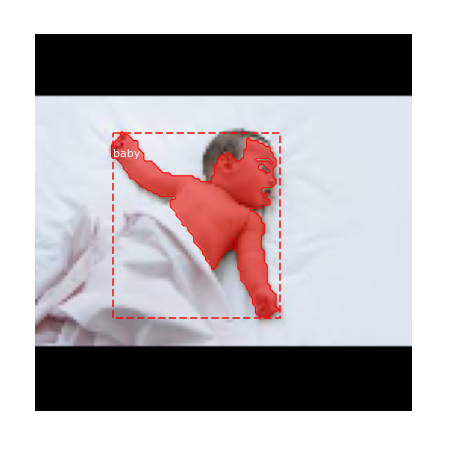

In [13]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (128, 128, 3)         min:    0.00000  max:  253.00000  uint8
molded_images            shape: (1, 128, 128, 3)      min: -123.70000  max:  149.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  128.00000  int64
anchors                  shape: (1, 4092, 4)          min:   -0.71267  max:    1.20874  float32


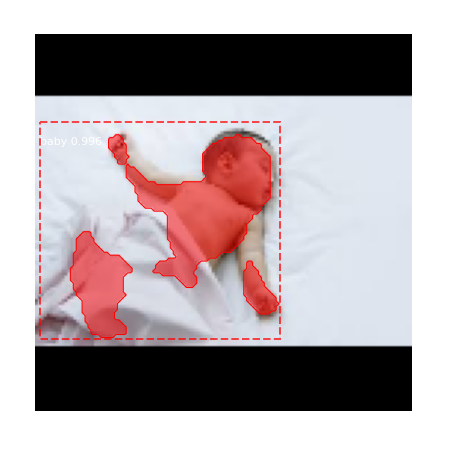

In [14]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

## Evaluation

In [15]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

mAP:  0.8
